In [1]:
import qcodes as qc
from qcodes import Parameter
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import load_by_id
from qcodes.instrument_drivers.NI.PXI_6251 import PXI_6251

import nidaqmx
from matplotlib import pyplot as plt
import numpy as np

import time

from lmfit import Model

In [2]:
%matplotlib notebook

In [3]:
daq = PXI_6251('daq', 'PXI-6115')

# Start/stop

In [11]:
sampling_rate_Hz = 333333
sampling_time_s = 2.5
N_samps = int(sampling_rate_Hz*sampling_time_s)
N_samps

833332

In [4]:
daq.add_task("ai_task")

In [5]:
daq.ai_task.add_ai_volt_channel('AWG','PXI-6115/ai0',
        terminal_config=nidaqmx.constants.TerminalConfiguration.PSEUDODIFFERENTIAL,
        min_val=-5,
        max_val=5)

In [6]:
daq.ai_task.add_sample_clock(sampling_rate_Hz, source='/PXI-6115/ai/SampleClockTimebase',
                             sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                             samps_per_chan=N_samps)

daq.ai_task.start_trigger.trig_type.set(nidaqmx.constants.TriggerType.DIGITAL_EDGE)
daq.ai_task.start_trigger.dig_edge_src.set('/PXI-6115/PFI0')

In [7]:
daq.ai_task.AIRead.prepare_AIRead()

In [8]:
daq.ai_task.start()

while not daq.ai_task._task.is_task_done():
    time.sleep(0.1)

res = daq.ai_task.AIRead.get()

daq.ai_task.stop()

In [10]:
len(res)

833332

In [12]:
daq.ai_task.close()

# Counter

## counter test

In [50]:
sampling_rate_Hz = 333333
sampling_time_s = 0.5
N_samps = int(sampling_rate_Hz*sampling_time_s)
N_samps

166666

In [57]:
daq.add_task("co_task")

daq.co_task.add_co_freq_channel('co', 'PXI-6115/ctr0', freq=sampling_rate_Hz)

daq.co_task.add_implicit_clock(sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                               samps_per_chan=N_samps)

daq.co_task.start_trigger.trig_type.set(nidaqmx.constants.TriggerType.DIGITAL_EDGE)
daq.co_task.start_trigger.dig_edge_src.set('/PXI-6115/PFI0')
daq.co_task.start_trigger.retriggerable.set(True)

In [58]:
daq.co_task.start()

In [59]:
daq.co_task.stop()

In [60]:
daq.co_task.close()

## with synced AI acquisition

In [187]:
sampling_rate_Hz = 333333
sampling_time_s = 0.5/2
N_samps = int(sampling_rate_Hz*sampling_time_s + 2)
dN_samps = 18 - N_samps % 2**4
N_co = N_samps + dN_samps
act_sampling_time_s = (N_samps-1)/sampling_rate_Hz
co_time_s = (N_co-1)/sampling_rate_Hz
N_samps, N_samps % 2**4, dN_samps, N_co, act_sampling_time_s, co_time_s

(83335, 7, 11, 83346, 0.25000225000225, 0.25003525003525)

In [188]:
daq.add_task("ai_task")

daq.ai_task.add_ai_volt_channel('AWG','PXI-6115/ai0',
        terminal_config=nidaqmx.constants.TerminalConfiguration.PSEUDODIFFERENTIAL,
        min_val=-5,
        max_val=5)

daq.ai_task.AWG.ai_coupling.set(nidaqmx.constants.Coupling.DC)

daq.ai_task.add_sample_clock(sampling_rate_Hz, source='/PXI-6115/Ctr0InternalOutput',
                             sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,
                             samps_per_chan=N_samps + 1000)

In [189]:
daq.add_task("co_task")

daq.co_task.add_co_freq_channel('co', 'PXI-6115/ctr0', freq=sampling_rate_Hz)

daq.co_task.add_implicit_clock(sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                               samps_per_chan=N_co)

daq.co_task.start_trigger.trig_type.set(nidaqmx.constants.TriggerType.DIGITAL_EDGE)
daq.co_task.start_trigger.dig_edge_src.set('/PXI-6115/PFI0')
daq.co_task.start_trigger.retriggerable.set(True)

In [190]:
daq.ai_task.AIRead.prepare_AIRead(setpointlist = tuple(np.arange(N_samps)/sampling_rate_Hz))

In [191]:
daq.ai_task.start()
daq.co_task.start()

In [294]:
while not daq.co_task.co.co_pulse_done.get():
    if daq.ai_task._task.in_stream.avail_samp_per_chan > 0:
        print(f"samples: {daq.ai_task._task.in_stream.avail_samp_per_chan}") 
    time.sleep(.05)

print(f"final samples: {daq.ai_task._task.in_stream.avail_samp_per_chan}")

samples: 5760
samples: 23728
samples: 41040
samples: 58464
samples: 76048
final samples: 83344


In [295]:
res_co = np.array(daq.ai_task.AIRead.get())

N_leftovers = 0 if (len(np.where(np.diff(res_co) < -1)[0]) == 0) else np.where(np.diff(res_co) < -1)[0][0] + 1

res = res_co[N_leftovers:N_leftovers+N_samps]

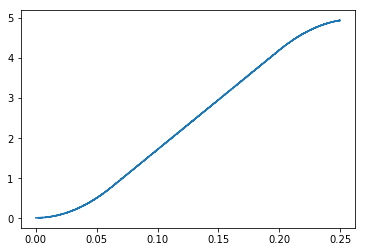

In [296]:
plt.plot(daq.ai_task.AIRead.setpoints[0][0], res)

In [297]:
daq.ai_task.stop()
daq.co_task.stop()

In [298]:
daq.ai_task.close()
daq.co_task.close()

## with synced AI acquisition on 3 channels

In [4]:
sampling_rate_Hz = 5e6
sampling_time_s = 0.525/2
N_samps = int(sampling_rate_Hz*sampling_time_s + 2)
dN_samps = 18- N_samps % 2**4
N_co = N_samps + dN_samps
act_sampling_time_s = (N_samps-1)/sampling_rate_Hz
co_time_s = (N_co-1)/sampling_rate_Hz
N_samps, N_co, act_sampling_time_s, co_time_s

(1312502, 1312514, 0.2625002, 0.2625026)

In [5]:
daq.add_task("ai_task")

daq.ai_task.add_ai_volt_channel('PDt','PXI-6115/ai0',
        terminal_config=nidaqmx.constants.TerminalConfiguration.PSEUDODIFFERENTIAL,
        min_val=-.1,
        max_val=1)

daq.ai_task.add_ai_volt_channel('PDr','PXI-6115/ai1',
        terminal_config=nidaqmx.constants.TerminalConfiguration.PSEUDODIFFERENTIAL,
        min_val=-.1,
        max_val=1)

daq.ai_task.add_ai_volt_channel('AWG','PXI-6115/ai2',
        terminal_config=nidaqmx.constants.TerminalConfiguration.PSEUDODIFFERENTIAL,
        min_val=-5,
        max_val=5)

daq.ai_task.AWG.ai_coupling.set(nidaqmx.constants.Coupling.DC)

daq.ai_task.add_sample_clock(sampling_rate_Hz, source='/PXI-6115/Ctr0InternalOutput',
                             sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,
                             samps_per_chan=N_samps + 1000)

In [6]:
daq.add_task("co_task")

daq.co_task.add_co_freq_channel('co', 'PXI-6115/ctr0', freq=sampling_rate_Hz)

daq.co_task.add_implicit_clock(sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                               samps_per_chan=N_co)

daq.co_task.start_trigger.trig_type.set(nidaqmx.constants.TriggerType.DIGITAL_EDGE)
daq.co_task.start_trigger.dig_edge_src.set('/PXI-6115/PFI0')
daq.co_task.start_trigger.retriggerable.set(True)

In [7]:
daq.ai_task.AIRead.prepare_AIRead(setpointlist = tuple(np.arange(N_samps)/sampling_rate_Hz))

In [8]:
daq.ai_task.start()
daq.co_task.start()

In [30]:
while not daq.co_task.co.co_pulse_done.get():
    if daq.ai_task._task.in_stream.avail_samp_per_chan > 0:
        print(f"samples: {daq.ai_task._task.in_stream.avail_samp_per_chan}") 
    time.sleep(.05)
time.sleep(.5)
print(f"final samples: {daq.ai_task._task.in_stream.avail_samp_per_chan}")

samples: 148766
samples: 417377
samples: 686188
samples: 946922
samples: 1211125
final samples: 1312512


In [31]:
res_co = np.array(daq.ai_task.AIRead.get())

In [32]:
N_leftovers = 0 if (len(np.where(np.diff(res_co[2]) < -1)[0]) == 0) else np.where(np.diff(res_co[2]) < -1)[0][0] + 1
res = res_co[:,N_leftovers:N_leftovers+N_samps]
print(N_leftovers)

2


<IPython.core.display.Javascript object>


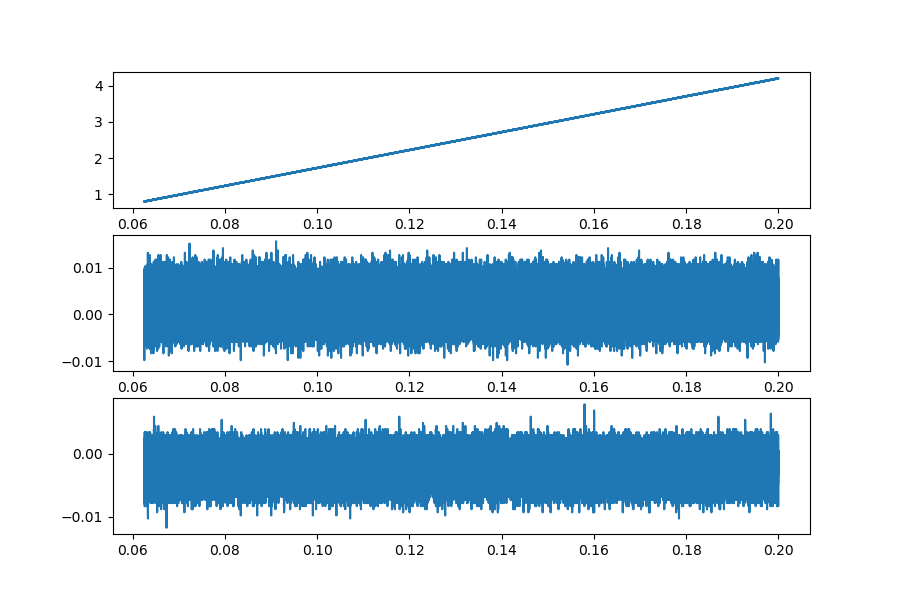

In [33]:
times = np.array(daq.ai_task.AIRead.setpoints[0][0])
dt_accel = (0.525/2 - 0.1375)/2
time_mask = (times > dt_accel) & (times < 0.525/2 - dt_accel)

fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(9,6))
ax1.plot(times[time_mask], res[2][time_mask])
ax2.plot(times[time_mask], res[1][time_mask])
ax3.plot(times[time_mask], res[0][time_mask])

In [34]:
daq.ai_task.stop()
daq.co_task.stop()

In [35]:
daq.ai_task.close()
daq.co_task.close()

# proper retriggerable AI